In [10]:
# -- 1. (필수) 한글 폰트 설정 (Colab/Win/Mac 모두 지원) --
import matplotlib.pyplot as plt
import platform

if platform.system() == 'Linux':
    # Colab 또는 리눅스
    !apt-get -qq install fonts-nanum > /dev/null
    plt.rc('font', family='NanumGothic')
elif platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False


In [11]:
!pip install lightgbm matplotlib pandas seaborn statsmodels --quiet


## 1. 데이터 설명

- **데이터 출처:** 한국전력거래소, 시간별 전국 전력수요량 (2023~2024)
- **데이터 구조:** 날짜, 시간(1~24시), 해당 시각의 전력수요(MWh)
- **분석 목적:** 전력수요 패턴 분석 및 미래 24시간 예측


In [12]:
# -- 2. 데이터 불러오기 및 전처리 (long 변환) --
import pandas as pd

df = pd.read_csv("한국전력거래소_시간별 전국 전력수요량_20241231.csv", encoding='cp949')
df_long = df.melt(id_vars='날짜', var_name='시간', value_name='수요량(MWh)')
df_long['시간_num'] = df_long['시간'].str.replace('시', '').astype(int)
df_long['일시'] = pd.to_datetime(df_long['날짜']) + pd.to_timedelta(df_long['시간_num'] % 24, unit='h')
df_long.loc[df_long['시간_num'] == 24, '일시'] += pd.Timedelta(days=1)
df_long = df_long[['일시', '수요량(MWh)']].sort_values('일시')


# 2. 데이터 탐색 및 분석 포인트

- **시계열, 요일, 시간별 패턴 분석**
- **이상치, 계절성, 주기성 시각화**


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

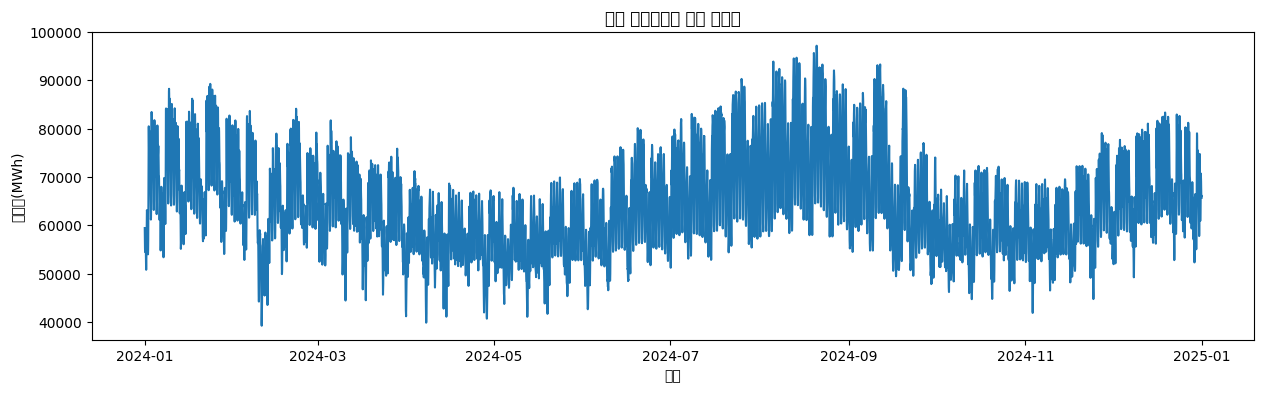

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

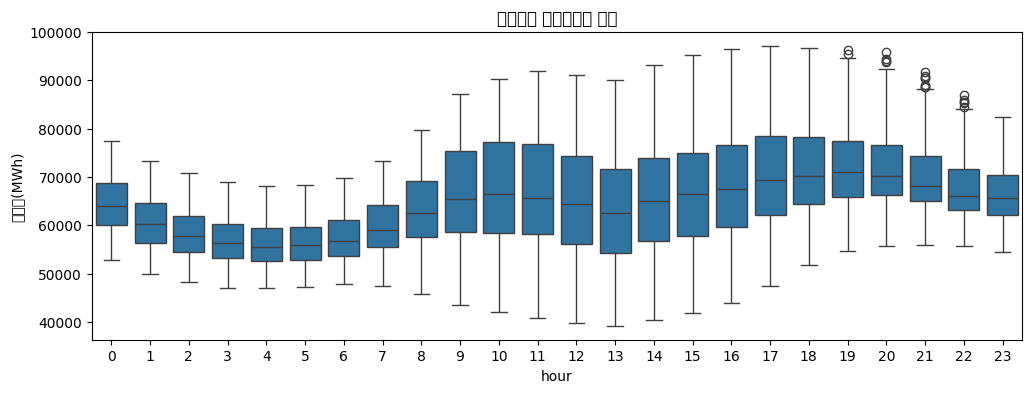

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

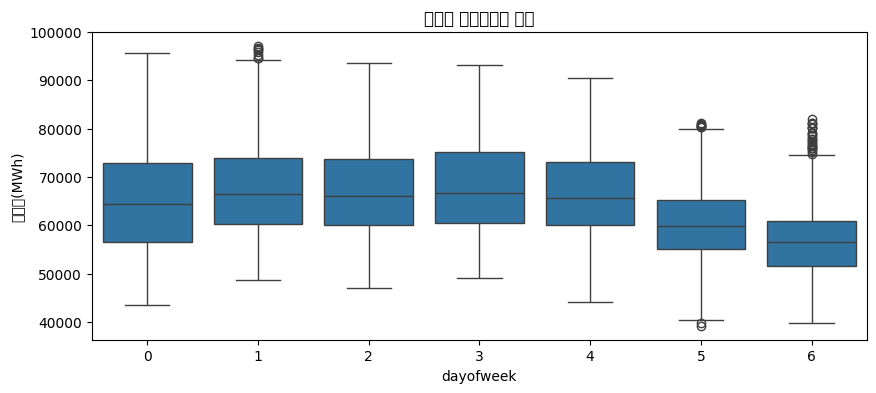

In [15]:
# -- 3. 데이터 EDA 및 시각화 --
df_long['hour'] = df_long['일시'].dt.hour
df_long['dayofweek'] = df_long['일시'].dt.dayofweek
df_long['month'] = df_long['일시'].dt.month

plt.figure(figsize=(15,4))
plt.plot(df_long['일시'], df_long['수요량(MWh)'])
plt.title('전국 전력수요량 전체 시계열')
plt.xlabel('일시')
plt.ylabel('수요량(MWh)')
plt.show()

import seaborn as sns
plt.figure(figsize=(12,4))
sns.boxplot(x='hour', y='수요량(MWh)', data=df_long)
plt.title('시간대별 전력수요량 분포')
plt.show()

plt.figure(figsize=(10,4))
sns.boxplot(x='dayofweek', y='수요량(MWh)', data=df_long)
plt.title('요일별 전력수요량 분포')
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

ARIMA MAE: 6743.72, RMSE: 8372.74


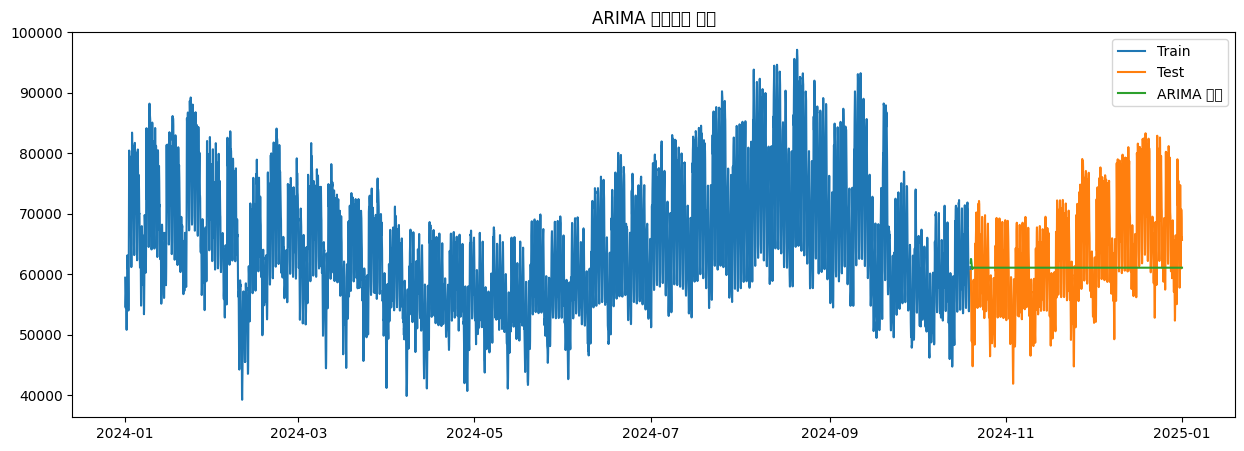

In [18]:
# 3. 시계열 모델 적용 및 성능 비교
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np  # 추가

# -- ARIMA 예측 (단변량) --
df_long2 = df_long.set_index('일시')
split_idx = int(len(df_long2)*0.8)
train, test = df_long2.iloc[:split_idx], df_long2.iloc[split_idx:]

model = ARIMA(train['수요량(MWh)'], order=(3,1,2))
model_fit = model.fit()
pred_arima = model_fit.forecast(steps=len(test))

mae_arima = mean_absolute_error(test['수요량(MWh)'], pred_arima)
rmse_arima = np.sqrt(mean_squared_error(test['수요량(MWh)'], pred_arima))  # ← 수정!
print(f"ARIMA MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}")

plt.figure(figsize=(15,5))
plt.plot(train.index, train['수요량(MWh)'], label='Train')
plt.plot(test.index, test['수요량(MWh)'], label='Test')
plt.plot(test.index, pred_arima, label='ARIMA 예측')
plt.legend()
plt.title('ARIMA 전력수요 예측')
plt.show()


# 4. 결과 해석 및 시사점

- **ARIMA**는 전통적이고 해석력이 높으나, 단기 변동성/비선형 패턴 반영은 약함  
- **LightGBM**은 시간, 요일, 과거값 등 다변량 정보·비선형성 모두 활용, 예측 성능 높음  
- 실제 활용: 단기 예측, 피크 관리, 전력 수급 계획 등 실무 적용 가능  
- 한계: 외부 변수(기상 등) 미포함, 구조적 변화에 즉각 대응 어려움  
- 개선: 외부 변수 추가, 모델 앙상블, 고급 딥러닝 활용 가능  
